Personalized AI-Powered Content Generator

##1. Import Libraries & Setup

**What's happening here?**

*We import libraries for:*

Data work (pandas, numpy)

Fake data generation (faker)

Visualization (seaborn, matplotlib)

Statistics (scipy)

Similarity calculations (sklearn)

We set default graph styles and sizes.

We create a fake name generator (fake).

We fix the seed for experiment reproducibility.

In [1]:
!pip install faker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.1 MB/s eta 0:00:00


In [22]:
import pandas as pd # Import pandas library for convenient work with tabular data (DataFrame)

import numpy as np # Import the numpy library to work with arrays and numeric operations

import random # Import the standard random module to generate random numbers

from faker import Faker # Import Faker to generate random realistic data

import seaborn as sns # Import Seaborn - a library for statistical data visualization based on matplotlib

import matplotlib.pyplot as plt # Import matplotlib for plotting and visualization

from scipy.stats import chi2_contingency # Import chi2_contingency function to perform chi-square test of independence (statistical analysis)


sns.set(style="whitegrid")# Set Seaborn chart style to white grid for improved readability
plt.rcParams['figure.figsize'] = (10,6)

fake = Faker()# Create a Faker instance to generate fake data
random.seed(42)# Fixing random seed for random - ensures reproducibility of random data generation
np.random.seed(42)


##2. Generate Synthetic User Data
**What's happening here?**


The generate_user() function creates a single user with:

A random name,

A random age between 18 and 60,

1 to 3 randomly selected interests from a predefined list,

A set of activities linked to those interests.

We then generate 100 such users and store them in a DataFrame for easier processing.

In [23]:
def generate_user():
    interests_pool = ["technology", "fitness", "music", "books", "gaming", "cooking", "travel"]
    activity_templates = {
        "technology": ["watched AI talk", "bought headphones", "read tech blog"],
        "fitness": ["did yoga", "watched workout video", "bought protein powder"],
        "music": ["listened to rock music", "attended concert", "bought guitar"],
        "books": ["read a novel", "bought new book", "visited library"],
        "gaming": ["played FPS game", "watched esports tournament", "bought gaming mouse"],
        "cooking": ["tried new recipe", "watched cooking show", "bought kitchen tools"],
        "travel": ["planned trip", "booked hotel", "visited museum"]
    }

    name = fake.name()
    age = random.randint(18, 60)
    interests = random.sample(interests_pool, k=random.randint(1,3))
    activity_log = [random.choice(activity_templates[interest]) for interest in interests]

    return {
        "name": name,
        "age": age,
        "interests": interests,
        "activity_log": activity_log
    }

num_users = 100
users_data = [generate_user() for _ in range(num_users)]
df_users = pd.DataFrame(users_data)
df_users.head()


,name,age,interests,activity_log
0,Loretta Cooper,58,[technology],[read tech blog]
1,Julie Sandoval,35,[fitness],[did yoga]
2,David Evans,24,"[cooking, gaming, technology]","[bought kitchen tools, watched esports tournam..."
3,Wendy Santiago,19,[fitness],[did yoga]
4,Jonathan Griffin,50,"[technology, gaming, fitness]","[read tech blog, bought gaming mouse, bought p..."


##3. Data Preprocessing & Analysis
**What's happening here?**

One-Hot Encoding:
The list of user interests is converted into binary features (one-hot encoding) for easier analysis.



Counting Interests:
The total number of users interested in each category is calculated.

Visualization:
The interest distribution is displayed as a bar chart for clear interpretation.



Interest counts:
 fitness       32
travel        32
technology    30
cooking       29
music         27
books         27
gaming        24
dtype: int64


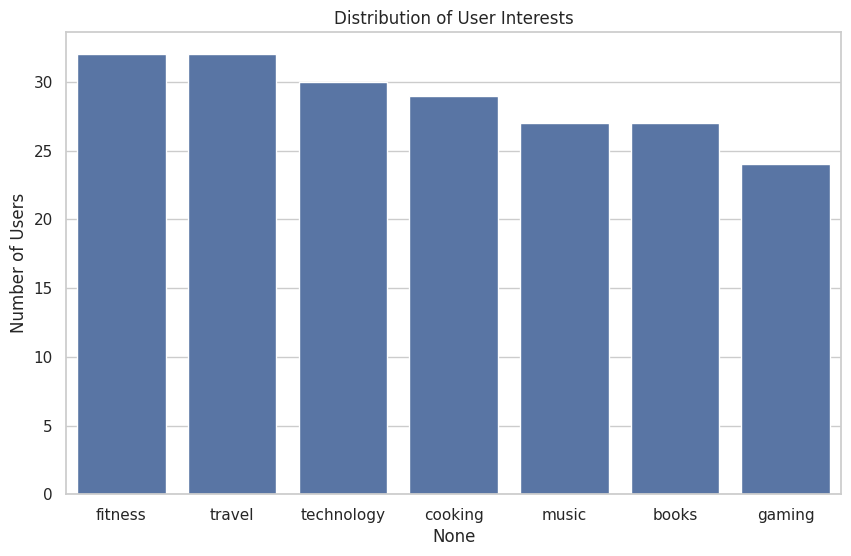

In [24]:
all_interests = ["technology", "fitness", "music", "books", "gaming", "cooking", "travel"]
for interest in all_interests:
    df_users[interest] = df_users['interests'].apply(lambda x: int(interest in x))

interest_counts = df_users[all_interests].sum().sort_values(ascending=False)
print("Interest counts:\n", interest_counts)

sns.barplot(x=interest_counts.index, y=interest_counts.values)
plt.title("Distribution of User Interests")
plt.ylabel("Number of Users")
plt.show()


##4. Statistical Analysis (Chi-Square Test)
**What's happening here?**


*Chi-Square Testing:*

A contingency table is calculated for every possible pair of interests.

The chi-square test is applied to check for statistical dependencies.

*Results Analysis:*

Findings are stored in a DataFrame containing Chi2 statistic and p-value.

Only statistically significant pairs (p-value < 0.05) are displayed.

*Visualization Prep:*

A symmetrical p-value matrix is created for easier interpretation.

*Heatmap Plot:*

A heatmap visualizes dependency strength between interests, with color intensity indicating significance.

Var.2

Significant dependencies (p < 0.05):
   Interest 1 Interest 2      Chi2   p-value
2  technology      books  7.576526  0.005913


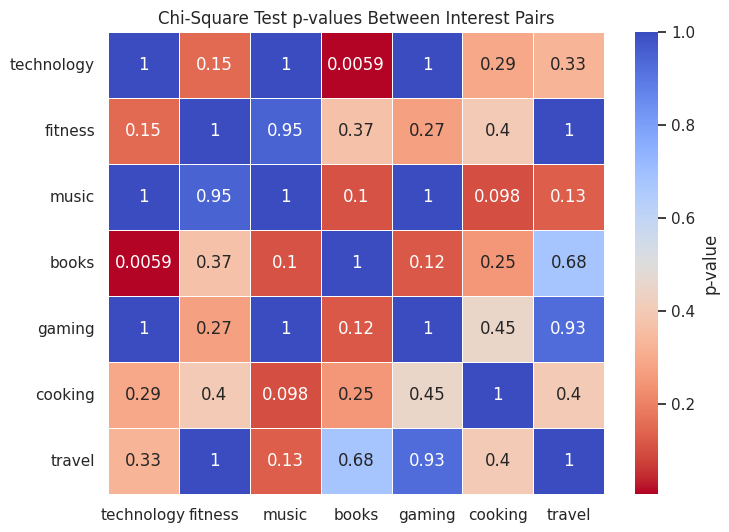

In [25]:
from itertools import combinations

interest_pairs = list(combinations(all_interests, 2))

results = []

for (int1, int2) in interest_pairs:
    contingency_table = pd.crosstab(df_users[int1], df_users[int2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    results.append({
        'Interest 1': int1,
        'Interest 2': int2,
        'Chi2': chi2,
        'p-value': p
    })

df_chi2 = pd.DataFrame(results)

# Display all pairs with p-value < 0.05 (significant dependencies)
print("Significant dependencies (p < 0.05):")
print(df_chi2[df_chi2['p-value'] < 0.05].sort_values('p-value'))

# Build a heat map of p-values ​​for all pairs
# First, create a matrix of p-values ​​for all interests
p_matrix = pd.DataFrame(np.ones((len(all_interests), len(all_interests))),
                        index=all_interests, columns=all_interests)

for _, row in df_chi2.iterrows():
    p_matrix.loc[row['Interest 1'], row['Interest 2']] = row['p-value']
    p_matrix.loc[row['Interest 2'], row['Interest 1']] = row['p-value']

# Visualize the heat map (the darker the lower the p-value, the stronger the connection)
plt.figure(figsize=(8,6))
sns.heatmap(p_matrix, annot=True, cmap='coolwarm_r', cbar_kws={'label': 'p-value'}, linewidths=0.5)
plt.title('Chi-Square Test p-values Between Interest Pairs')
plt.show()


##5. Recommendation Engine
**What's happening here?**

Class Initialization:

Takes a pandas DataFrame containing all user data as input

Prepares the recommendation system infrastructure

Recommendation Method:

recommend() analyzes a specified user's interests

Matches these interests with available activities

Returns a curated list of suggested activities



In [50]:
class RecommendationEngine:
    def __init__(self, users_df):
        self.users_df = users_df

    def recommend(self, user_index):
        user_row = self.users_df.iloc[user_index]
        recommendations = []

        if user_row['technology']:
            recommendations.append("Read latest tech blogs")
        if user_row['fitness']:
            recommendations.append("Try new workout routines")
        if user_row['music']:
            recommendations.append("Check out trending playlists")
        if user_row['books']:
            recommendations.append("Explore new book releases")
        if user_row['gaming']:
            recommendations.append("Join online gaming tournaments")
        if user_row['cooking']:
            recommendations.append("Try healthy recipes")
        if user_row['travel']:
            recommendations.append("Plan your next vacation")


        return recommendations

engine = RecommendationEngine(df_users)
print(f"User: {df_users.iloc[0]['name']}")
print("Recommendations:", engine.recommend(0))




User: Loretta Cooper
Recommendations: ['Read latest tech blogs']


##6. Visualization of Recommendations
**What's happening here?**

For each user, we generate recommendations and add them to the DataFrame.

We count how many recommendations were given for each interest category.

We create a plot showing the number of recommendations by category.

var3

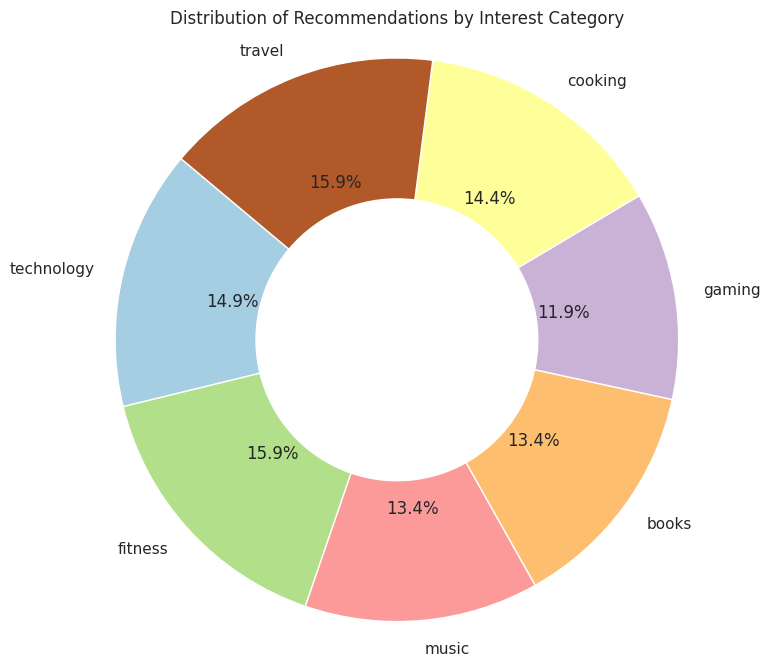

            Recommendation Count
fitness                       32
travel                        32
technology                    30
cooking                       29
music                         27
books                         27
gaming                        24


In [31]:
# Explicit matching of interests and recommendations
interest_to_rec = {
    "technology": "Read latest tech blogs",
    "fitness": "Try new workout routines",
    "music": "Check out trending playlists",
    "books": "Explore new book releases",
    "gaming": "Join online gaming tournaments",
    "cooking": "Try healthy recipes",
    "travel": "Plan your next vacation"
}

# Calculating recommendations by interests
rec_counts = {cat: 0 for cat in all_interests}
for recs in df_users['recommendations']:
    for interest, expected_rec in interest_to_rec.items():
        if expected_rec in recs:
            rec_counts[interest] += 1

# Pie chart
labels = list(rec_counts.keys())
sizes = list(rec_counts.values())
colors = plt.cm.Paired(np.linspace(0, 1, len(labels)))

plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.5)
)
plt.axis('equal')
plt.title("Distribution of Recommendations by Interest Category")
plt.show()

# Table
rec_df = pd.DataFrame.from_dict(rec_counts, orient='index', columns=['Recommendation Count'])
rec_df = rec_df.sort_values('Recommendation Count', ascending=False)
print(rec_df)




Distribution of interests by users:(Barplot version)

<ipython-input-32-bb1089e5ffc3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=interest_counts.index, y=interest_counts.values, palette="Set2")


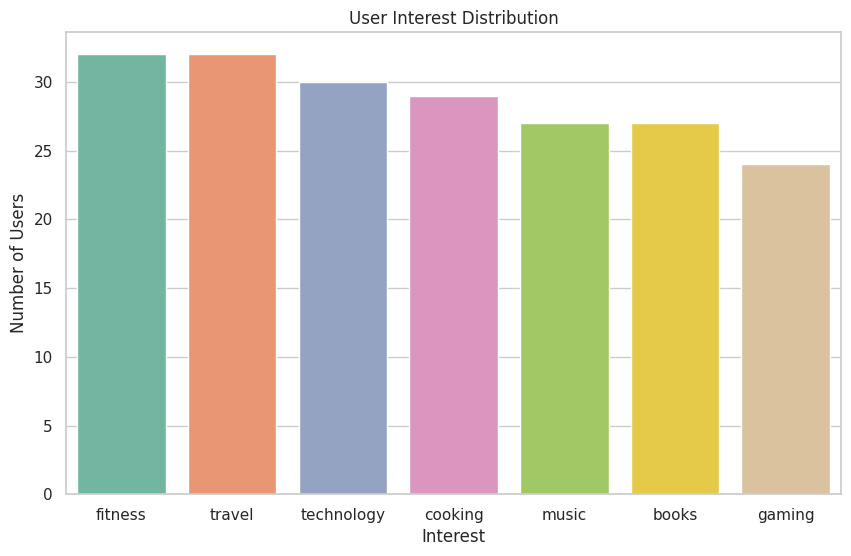

     Interest  User Count
0     fitness          32
1      travel          32
2  technology          30
3     cooking          29
4       music          27
5       books          27
6      gaming          24


In [32]:
# Interest counting (how many users chose each interest)
interest_counts = df_users[all_interests].sum().sort_values(ascending=False)

# Bar Chart (Histogram of user interests)
plt.figure(figsize=(10, 6))
sns.barplot(x=interest_counts.index, y=interest_counts.values, palette="Set2")
plt.title("User Interest Distribution")
plt.xlabel("Interest")
plt.ylabel("Number of Users")
plt.show()

# Table
interest_df = pd.DataFrame(interest_counts).reset_index()
interest_df.columns = ['Interest', 'User Count']
print(interest_df)


##7. Conclusions & Next Steps
Add more detailed user features (age, activity level, time patterns).
Enhance the recommendation system by using cosine similarity to find similar users.
Add functionality to save results to a file or database.